![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir si el precio del automóvil es alto o no. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

# Visualización dataset
data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
7,2014,6480,0,0,0,1,0,0,0,1
11,2014,39972,0,0,0,0,1,0,0,0
167,2016,18989,0,0,0,0,0,1,0,1
225,2014,51330,0,0,0,1,0,0,0,0
270,2007,116065,0,1,0,0,0,0,0,0


In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [4]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el acurracy del modelo en el set de test.

In [5]:
# Celda 1

import numpy as np

# Definición de parámetros y criterios de parada
max_depth = None
num_pct = 10
max_features = None
min_gain=0.001

# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j
#dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split


# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=3, num_pct=10)

# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree' 
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

y_predicted=tree_predict(X_test, tree)

# Calculo de accuracy
from sklearn.metrics import accuracy_score
accuracy_1=accuracy_score(y_test, y_predicted)
print('accuracy del árbol de decision: ', accuracy_1)

accuracy del árbol de decision:  0.8778868360277137


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de clasificación y comenten sobre el desempeño del modelo.

In [6]:
# Celda 2

# Se crea un arreglo de 1 a 20
np.random.seed(1)
# Impresión de arreglo y muestreo aleatorio
nums = np.arange(1, 21)
print('Arreglo:', nums)
print('Muestreo aleatorio: ', np.random.choice(a=nums, size=20, replace=True))

Arreglo: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Muestreo aleatorio:  [ 6 12 13  9 10 12  6 16  1 17  2 13  8 14  7 19  6 19 12 11]


In [7]:
# Creación de 10 muestras de bootstrap 
np.random.seed(123)
n_samples = X_train.shape[0]
n_B = 10
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

[array([3582, 3454, 1346, ...,  826,  801, 5657]),
 array([6962, 3408, 2553, ..., 6611,  877, 6412]),
 array([1917, 3131,  384, ..., 2876, 6449, 6557]),
 array([3849, 4565, 6820, ..., 6835, 4643,  639]),
 array([2468, 3608, 1367, ..., 3108, 2961, 4357]),
 array([3142, 1537, 5966, ..., 3224, 6922, 3396]),
 array([6588, 3753, 1786, ..., 2131, 4627, 5672]),
 array([1289, 3776,  981, ..., 1891, 6034, 6165]),
 array([6079, 3819, 6976, ..., 6478, 2225, 5072]),
 array([3952, 3276,  896, ..., 4589, 1964,  893])]

In [8]:
# Visualización muestra boostrap #1 para entremiento
X_train.iloc[samples[0], :]

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
151599,2016,40999,0,0,0,0,0,1,0
171999,2014,52527,0,0,0,0,0,1,0
304172,2009,123202,0,1,0,0,0,0,0
74828,2015,38807,0,0,0,0,0,1,0
192974,2005,51260,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
134843,2014,22221,0,0,0,0,1,0,0
325075,2013,86593,0,0,0,0,0,1,0
61213,2014,28044,0,0,0,0,0,1,0
181222,2016,49368,0,0,0,0,0,0,1


In [9]:
# Construcción un árbol de decisión para cada muestra boostrap

from sklearn.tree import DecisionTreeClassifier

# Definición del modelo usando sklearn
clf = DecisionTreeClassifier(max_depth=None, random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=y_test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    X_train_2 = X_train.iloc[sample]
    y_train_2 = y_train.iloc[sample]
    clf.fit(X_train_2, y_train_2)
    y_pred.iloc[:,i] = clf.predict(X_test)
    
y_pred

,0,1,2,3,4,5,6,7,8,9
257343,0,0,0,0,0,0,0,0,0,0
326011,0,0,0,0,0,0,0,0,0,0
242354,1,1,1,1,1,1,1,1,1,1
266376,1,1,1,1,1,1,1,1,1,1
396954,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
144298,1,0,1,1,0,0,1,1,1,1
364521,1,1,1,1,1,1,1,1,1,1
120072,1,1,1,1,1,1,1,1,1,1
99878,0,0,0,0,0,0,0,0,0,0


In [10]:
y_pred_mode=y_pred.mode(axis=1)[0]
y_pred_mode

257343    0.0
326011    0.0
242354    1.0
266376    1.0
396954    1.0
         ... 
144298    1.0
364521    1.0
120072    1.0
99878     0.0
387162    0.0
Name: 0, Length: 3464, dtype: float64

In [11]:
# Calculo de accuracy
accuracy_2=accuracy_score(y_test, y_pred_mode)
print('accuracy de bagging manual: ', accuracy_2)

accuracy de bagging manual:  0.8507505773672055


El accuracy obtenido usando bagging manual es satisfactorio, pero es un resultado menor comparado con el decision tree manual. Esto pudo pasar por la aletoriedad. También se observa que no hay muchos cambios entre los distintos
árboles del bagging. Todos tienen un error similar de 0.4

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de clasificación y el parámetro `max_features` igual a `log(n_features)`. Presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [12]:
# Celda 3

# Uso de BaggingRegressor de la libreria (sklearn) donde se usa el modelo DecisionTreeRegressor como estimador
from sklearn.ensemble import BaggingClassifier
n_features=X_train.shape[1]
bagclf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=10, max_features=int(np.log(n_features)), 
                          bootstrap=True, oob_score=True, random_state=1)
bagclf.fit(X_train, y_train)

y_pred = bagclf.predict(X_test)

accuracy_3=accuracy_score(y_test, y_pred)
print('accuracy de bagging con librería: ', accuracy_3)

accuracy de bagging con librería:  0.8493071593533488


Se obtuvo un resultado satisfactorio, sólo hubo una diferencia mínima comparada con el bagging manual que se puede deber a la aletoriedad.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para clasificación y presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [13]:
# Celda 4

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt

# Definición de modelo Random Forest para un problema de clasificación
clf1 = RandomForestClassifier(n_estimators=7, random_state=1, n_jobs=-1)
clf1

RandomForestClassifier(n_estimators=7, n_jobs=-1, random_state=1)

In [14]:
clf1.fit(X_train, y_train)
y_pred = clf1.predict(X_test)
accuracy_4=accuracy_score(y_test, y_pred)
print('accuracy de random forest con libreria: ', accuracy_4)

accuracy de random forest con libreria:  0.8432448036951501


El accuracy con random forest mostró una mejoría comparada con los resultados de bagging y del árbol de decisión.
Tiene mucho sentido ya que random forest es un modelo con mejor desempeño pero menos interpretable.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

In [15]:
# Celda 5

from sklearn.model_selection import GridSearchCV

param_grid = [
{'n_estimators': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'max_features': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 'max_depth': [3,4,5,6]}
]
clf2 = RandomForestClassifier()

grid_search = GridSearchCV(clf2, param_grid, cv=5,
scoring='accuracy',
return_train_score=True)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [3, 4, 5, 6],
                          'max_features': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
                          'n_estimators': [6, 7, 8, 9, 10, 11, 12, 13, 14,
                                           15]}],
             return_train_score=True, scoring='accuracy')

In [16]:
grid_search.best_params_

{'max_depth': 6, 'max_features': 8, 'n_estimators': 11}

In [17]:
clf2 = RandomForestClassifier(n_estimators=15, max_depth=6, max_features=6, random_state=1, n_jobs=-1)

clf2.fit(X_train, y_train)
y_pred = clf2.predict(X_test)
accuracy_5=accuracy_score(y_test, y_pred)
print('accuracy de random forest con calibración: ', accuracy_5)

accuracy de random forest con calibración:  0.8868360277136259


In [18]:
# Impresión de resultados de desemepeño del modelo
feature_cols = X_train.columns[X_train.columns.str.startswith('C') == False]
pd.DataFrame({'feature':feature_cols, 'importance':clf2.feature_importances_}).sort_values('importance')

,feature,importance
4,M_CamryBase,0.000256
5,M_CamryL,0.002045
2,M_Camry,0.007061
7,M_CamrySE,0.010258
8,M_CamryXLE,0.010320
6,M_CamryLE,0.013600
3,M_Camry4dr,0.072563
0,Year,0.366145
1,Mileage,0.517754


Al hacer la calibración se mejora el desempeño previamente obtenido con random forest e hiperparametros predeterminados. Aumentar el número de estimadores mejora el accuracy y se encuentra un punto óptimo en 11. max_depth y max_features son estables en 6.

Revisando las features, se observa que Mileage y year son las variables más importantes, y después se encuentran las variables relacionadas con el modelo del auto.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de clasificación con la librería sklearn, presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [19]:
# Celda 6
from xgboost import XGBClassifier
clf3 = XGBClassifier()
clf3

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

In [20]:
# Entrenamiento (fit) y desempeño del modelo XGBClassifier
clf3.fit(X_train, y_train)
y_pred = clf3.predict(X_test)

accuracy_6=accuracy_score(y_test, y_pred)
print('accuracy de xgboost: ', accuracy_6)

accuracy de xgboost:  0.8856812933025404


XGBoost muestra mejores resultados con valores predeterminados que random forest sin calibración, por lo que seguramente XGBoost es el mejor modelo para este caso.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

In [21]:
# Celda 7

param_grid = [
{'learning_rate': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6],
 'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 2, 3, 4],
 'colsample_bytree': [1,2,3,4,5]}
]
clf4 = XGBClassifier()

grid_search = GridSearchCV(clf4, param_grid, cv=5,
scoring='accuracy',
return_train_score=True)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, va

In [22]:
grid_search.best_params_

{'colsample_bytree': 1, 'gamma': 4, 'learning_rate': 0.15}

In [23]:
# Entrenamiento (fit) y desempeño del modelo XGBClassifier
clf4 = XGBClassifier(colsample_bytree= 1, gamma= 4, learning_rate= 0.15)
clf4.fit(X_train, y_train)
y_pred = clf4.predict(X_test)

accuracy_7=accuracy_score(y_test, y_pred)
print('accuracy de xgboost con calibración: ', accuracy_7)

accuracy de xgboost con calibración:  0.8882794457274826


XGboost con calibración muestra los mejores resultados de accuracy comparado con los otros modelos. 

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

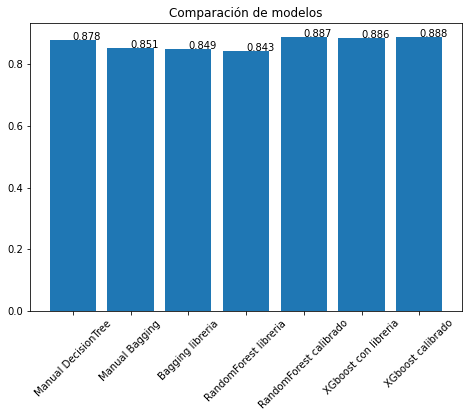

In [24]:
# Celda 8

accuracy_1 = round(accuracy_1, 3)
accuracy_2 = round(accuracy_2, 3)
accuracy_3 = round(accuracy_3, 3)
accuracy_4 = round(accuracy_4, 3)
accuracy_5 = round(accuracy_5, 3)
accuracy_6 = round(accuracy_6, 3)
accuracy_7 = round(accuracy_7, 3)

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_title('Comparación de modelos')
ejeX = ['Manual DecisionTree', 'Manual Bagging', 'Bagging libreria', 'RandomForest libreria',
        'RandomForest calibrado', 'XGboost con libreria', 'XGboost calibrado']
ejeY = [accuracy_1, accuracy_2, accuracy_3, accuracy_4, accuracy_5, accuracy_6, accuracy_7]
ax.bar(ejeX, ejeY)
plt.xticks(rotation=45)
def addlabels(x, y, plotP):
    for i in range(len(x)):
        plotP.text(i, y[i], y[i])
addlabels(ejeX, ejeY, plt)
plt.show()

Se observa que en general los resultados de todos los modelos son muy homogéneos. Definitivamente el uso de librerias mejora los resultados con RandomForest y XGboost, por otro lado la calibración mejora aún más el accuracy. Finalmente XGBoost con calibración presenta el mejor resultado, por lo que sería el modelo elegido.